<h1 align="center">EMOTION DETECTION</h1> 

<h3 align="center">IMAGE CLASSIFICATION MODEL</h3> 

### INTRODUCTION

<p style='text-align: justify;'> Life has become very convenient all thanks to the influence of machine learning in our day to day lives. Now, we are more productive than ever. We can accomplish many things with the help of technology in very less time and, alot of the things we used to do, don't require human interventions anymore because of automations. On the other hand, there are a few things still, that machines cannot do better than man and one of them is, identifying emotions. Emotions also, play a big role in our lives because it influences the way we think, decide, behave and has a great impact on our attitude. Combining these two is something not impossible but is a little bit challenging.

The best way to achieve this is through building an image classification model that could detect the emotions expressed by people in their photos. The goal is to create the best model that will be presented with photos, and the model will try to predict the outcome by returning the identified emotion depicted in the picture.</p>

### IMPORTED LIBRARIES

In [1]:
# pip install tensorflow

In [49]:
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Model
import numpy as np
import PIL
from PIL import Image
import efficientnet.keras as efn 
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report


from functions.visuals import *
from functions.check import score


### DATA INFORMATION

The data was collected from [Kaggle Emotion Detection](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer?select=train). The data folder mainly consists of two folders that contains image files. **Train folder** contains 7 classes of emotions that has 28,571 photos in total. **Test folder** also contains 7 classes of emotions and 7,178 images in total. Images were 48 x 48 pixel grayscale.

<p style='text-align: justify;'>After carefully diagnosing the dataset, it was identified that there were corrupted, blank and misclassified photos in each folder. To fix this problem, data cleansing was done by manually distributing the photos that belonged to its proper class folder (example: sad faces in happy folder were placed in sad folder, neutral faces in disgusted folder were placed in neutral folder). Corrupted and blank photos were deleted (about 100 photos). Images that did not belong to any folder were deleted as well (about 20 pictures of people yawning).</p>

### LOADING DATA
-Defining the parameters
<br> -Loading the images from our directory  

In [3]:
batch_size = 32                                # 32 images will be used in one iteration
img_size = [48, 48]                            # images are in 48 x 48 pixels

train = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/emotions/train"
test = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/emotions/test"

### SAMPLE PHOTO

HAPPY KIM KARDASHIAN


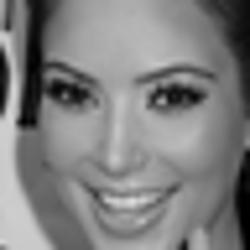

In [4]:
image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/emotions/train/happy/im2523.png"
print('\033[1m' + 'HAPPY KIM KARDASHIAN' + '\033[0m')
sampleimage(250, image)                        # 2 arguments: dimension of the photo, and photo url

### SPLITTING THE DATA:
**1. train_ds** - contains training dataset with 80% of the images
**<br>2. val_ds** - contains training dataset with 20% of the images
**<br>3. test_ds** - contains test dataset


In [5]:
# Getting train dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    train,                                 # directory
    labels="inferred",                     # labels were taken from directory
    shuffle = True,                        # shuffling data
    validation_split=0.2,                  # percentage of data to be used for validation
    subset= "training",                    # tells that subset belongs to training
    seed= 123,                             # random seed for shuffling
    image_size=(img_size),
    batch_size=batch_size)

Found 28571 files belonging to 7 classes.
Using 22857 files for training.


2022-12-01 11:37:49.146263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Getting validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    train,                                 
    labels="inferred",
    shuffle = True,                        
    validation_split=0.2,                  
    subset= "validation",                   # tells that subset belongs to validation
    seed= 123,                             
    image_size=(img_size),
    batch_size=batch_size)

Found 28571 files belonging to 7 classes.
Using 5714 files for validation.


In [7]:
# Getting test dataset

test_ds = tf.keras.utils.image_dataset_from_directory(
    test,                                 
    labels="inferred",
    shuffle = True,                                                     
    image_size=(img_size),
    batch_size=batch_size)

Found 7178 files belonging to 7 classes.


### IDENTIFYING CLASS NAMES

In [8]:
# Identifying all the emotion classes from our dataset

class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


### DATA VISUALIZATION

Plotting different sample photos with their corresponding class names (emotions).


<function functions.visuals.plotting_visualization(data, class_names)>

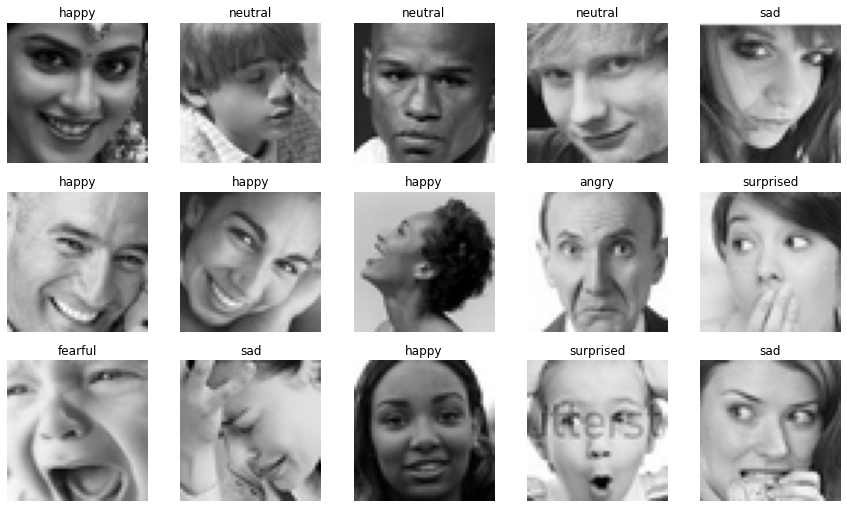

In [9]:
plotting_visualization(train_ds, class_names)     # 2 arguments: dataset name, class name variable

In [10]:
# Dataset iteration and fetching batches of images

# A batch of 32 images of shape 48 x 48, and color channel rgb which is represented by 3.
# Label_batch is shows the labels corresponding to the 32 images.


for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    


(32, 48, 48, 3)
(32,)


### CONFIGURING THE DATASET

Improves the performance by reducing the I/O.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### DATA AUGMENTATION

<p style='text-align: justify;'>Helps in artificially adding more sample data by transforming image rotations, flipping images horizontally and vertically, contrast and brightness adjustments and many more of the original training dataset. For this dataset, only three layers were stacked. This helps lessen the chances of overfitting.</p>

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)])

<function functions.visuals.augmented_data(data, data_augmentation)>

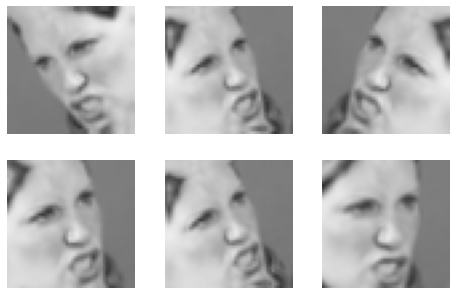

In [13]:
augmented_data(train_ds, data_augmentation)        # 2 arguments: dataset name, data augmentation variable

### MODEL CREATION

After creating and testing multiple models using different types of pre-trained models like VG16, DenseNet and Efficientnet, the best model came up by stacking different tensorflow kera layers such as data augmentation, maxpooling, rescaling, dropout and others and, tuning them to get the best possible accuracy score.

In [14]:
model = Sequential([
  data_augmentation,
    layers.Rescaling(1./255, input_shape=(48, 48, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(7, activation='softmax')
])

### MODEL COMPILING

Used in training the model which help identifies which optimizer is used, checks the loss function defined, and which metrics is defined to evaluate the model.

#### ARGUMENTS
**Optimzer - 'adams'** -- uses less memory and accelerates the gradient descent by looking at exponential weighted average.
<br>**Loss - 'SparseCategoricalCrossentropy'** -- used to calculate the computes the loss between labels and predictions.
<br>**Metrics - 'accuracy'** -- Calculates the times when prediction equals the class names.


In [15]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
# To view the layers of the model, UNCOMMENT THE MODEL SUMMARY

#model.summary()


**DEFINING EPOCHS** 
<br>Epochs - number of times the data will be trained

In [17]:
epochs = 25

In [18]:
# Fitting the training dataset and validation dataset with 25 epochs

history= model.fit(train_ds,validation_data=val_ds,
                      epochs=epochs)

Epoch 1/25


/Users/sarbjitmadra/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


715/715 [==============================] - 151s 204ms/step - loss: 1.7827 - accuracy: 0.2642 - val_loss: 1.7040 - val_accuracy: 0.3127
Epoch 2/25
715/715 [==============================] - 155s 217ms/step - loss: 1.6842 - accuracy: 0.3224 - val_loss: 1.5697 - val_accuracy: 0.3850
Epoch 3/25
715/715 [==============================] - 146s 204ms/step - loss: 1.5663 - accuracy: 0.3878 - val_loss: 1.5005 - val_accuracy: 0.4032
Epoch 4/25
715/715 [==============================] - 152s 212ms/step - loss: 1.4811 - accuracy: 0.4244 - val_loss: 1.3889 - val_accuracy: 0.4631
Epoch 5/25
715/715 [==============================] - 149s 208ms/step - loss: 1.4089 - accuracy: 0.4560 - val_loss: 1.3143 - val_accuracy: 0.4977
Epoch 6/25
715/715 [==============================] - 144s 201ms/step - loss: 1.3613 - accuracy: 0.4746 - val_loss: 1.2711 - val_accuracy: 0.4981
Epoch 7/25
715/715 [==============================] - 134s 188ms/step - loss: 1.3168 - accuracy: 0.4953 - val_loss: 1.2638 - val_accura

### EVALUATION

Helps measure the efficacy of the performance of the model and how well it will predict in the unseen data.

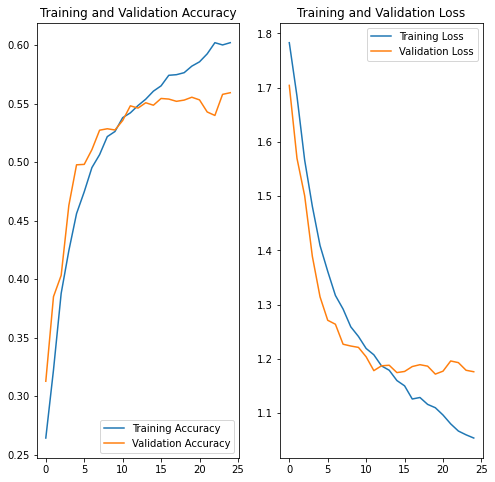

In [19]:
# Plotting accuracy and loss for both datasets.

plotting(history, epochs)                        # 2 arguments: history, number of epochs

In [20]:
score(train_ds, model, 1)                        # 3 arguments: dataset name, model name, number of verbose

715/715 [==============================] - 27s 38ms/step - loss: 1.1348 - accuracy: 0.5710
Loss: 1.1347688436508179 
 Accuracy: 0.5709848403930664


In [21]:
score(val_ds, model, 1)                        

179/179 [==============================] - 6s 36ms/step - loss: 1.1762 - accuracy: 0.5593
Loss: 1.1761959791183472 
 Accuracy: 0.5593279600143433


In [22]:
score(test_ds, model, 1) 

225/225 [==============================] - 9s 42ms/step - loss: 1.2107 - accuracy: 0.5475
Loss: 1.2106672525405884 
 Accuracy: 0.5475062727928162


### PREDICTIONS
Photos are taken from test dataset and free stock images websites.

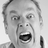

In [23]:
# SAMPLE 1

image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/emotions/test/angry/im43.png"
PIL.Image.open(image)

In [24]:
prediction_visuals(image, model, class_names)    # 3 arguments: image variable, model name, class name variable

1/1 [==============================] - 0s 149ms/step
This image most likely belongs to fearful .


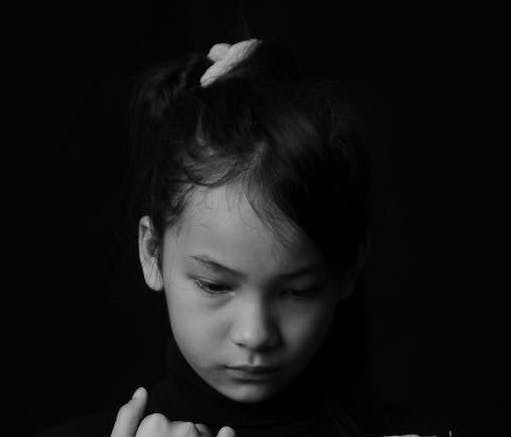

In [25]:
# SAMPLE 2

image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/images/sad.jpeg"
PIL.Image.open(image)

In [26]:
prediction_visuals(image, model, class_names)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to sad .


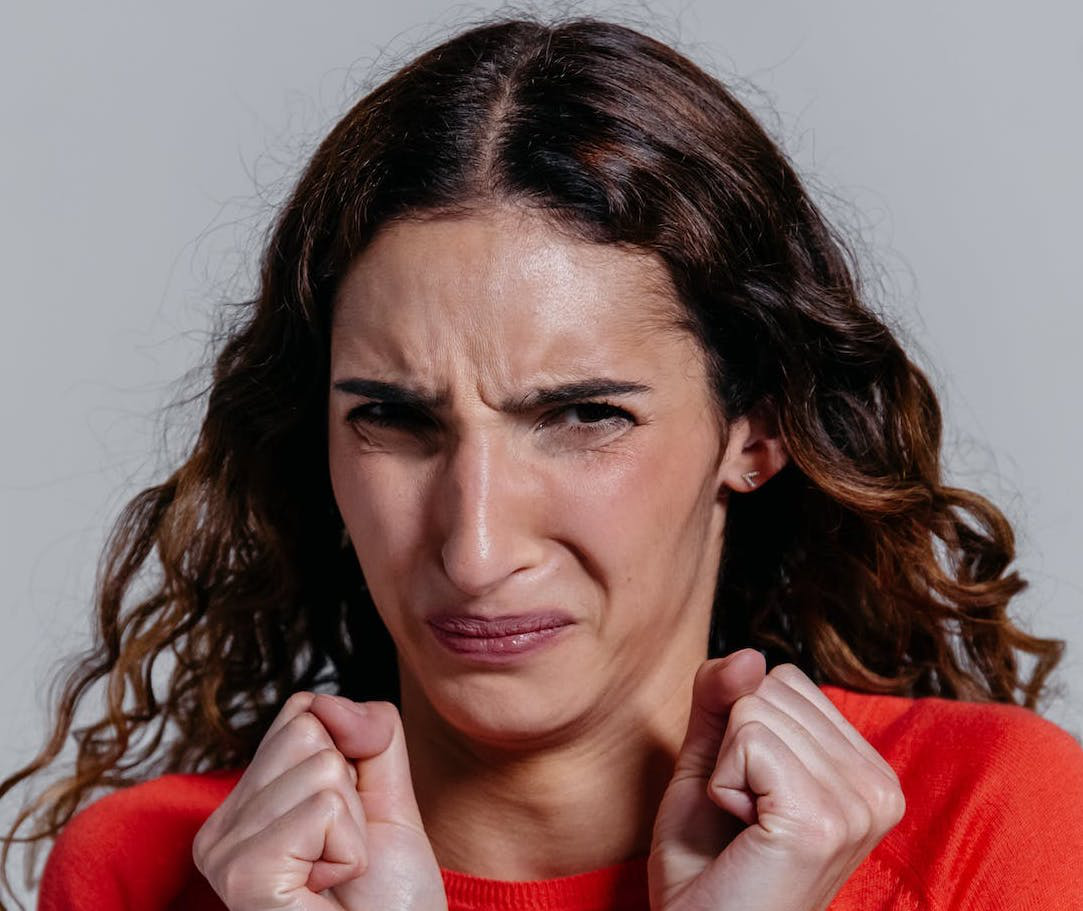

In [27]:
# SAMPLE 3

image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/images/image_002.jpeg"
PIL.Image.open(image)

In [28]:
prediction_visuals(image, model, class_names)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to sad .


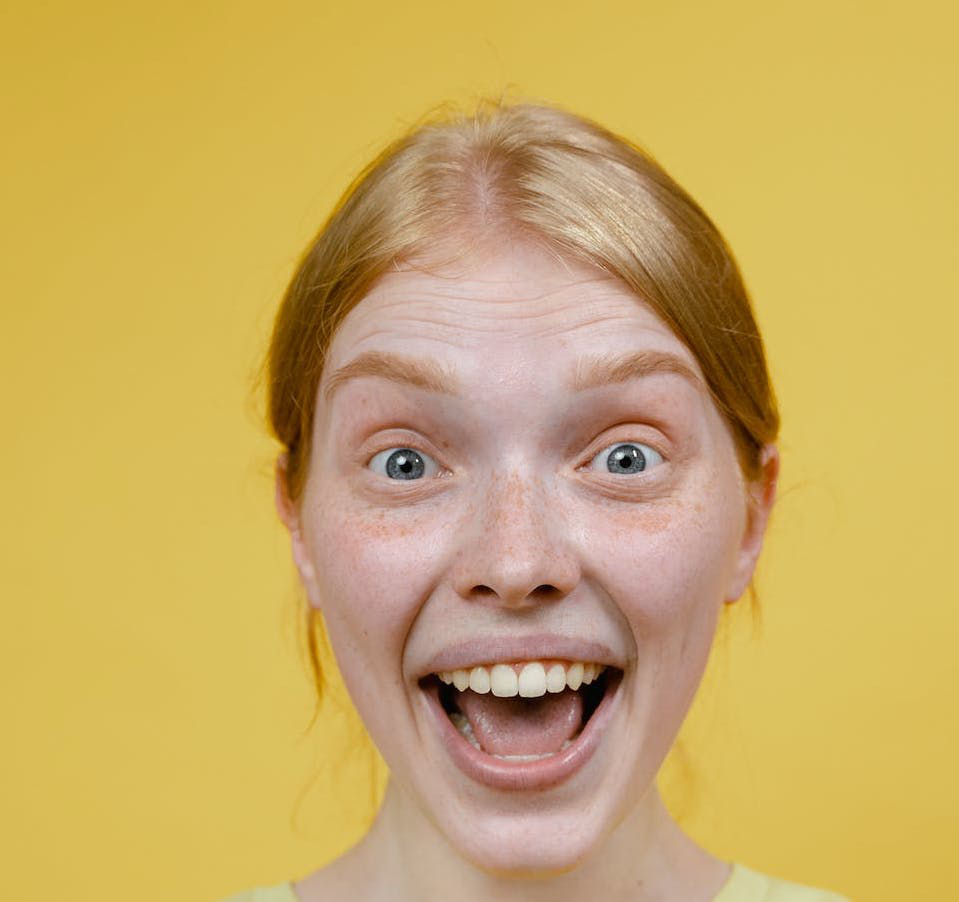

In [29]:
# SAMPLE 4 

image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/images/Surprised.jpeg"
PIL.Image.open(image)

In [30]:
prediction_visuals(image, model, class_names)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to happy .


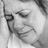

In [31]:
# SAMPLE 5 

image = "/Users/sarbjitmadra/Desktop/Concordia/emotion_detection/emotions/test/fearful/im184.png"
PIL.Image.open(image)

In [32]:
prediction_visuals(image, model, class_names)

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to fearful .


### MODEL CLASSIFICATION REPORT

In [70]:
y_true = []
for t, tensor in test_ds.unbatch().enumerate():
    array = tensor[1].numpy()
    y_true.append(array)


y_predict = model.predict(test_ds).argmax(axis=1)
print("\n", "0 = angry","\n","1 = disgusted","  2 = fearful","\n","3 = happy","      4 = neutral","\n","5 = sad","        6 = surprised")
print("\n", '\033[1m' + 'CLASSIFICATION REPORT' + '\033[0m')
print("\n", classification_report(y_true,y_predict)) 


2022-12-01 16:33:05.115146: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


225/225 [==============================] - 6s 27ms/step

 0 = angry 
 1 = disgusted   2 = fearful 
 3 = happy       4 = neutral 
 5 = sad         6 = surprised

 CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       0.42      0.46      0.44       958
           1       0.32      0.10      0.15       111
           2       0.36      0.21      0.27      1024
           3       0.78      0.81      0.80      1774
           4       0.48      0.53      0.51      1233
           5       0.43      0.44      0.44      1247
           6       0.61      0.74      0.67       831

    accuracy                           0.55      7178
   macro avg       0.49      0.47      0.47      7178
weighted avg       0.53      0.55      0.54      7178



In [61]:
confused = confusion_matrix(y_true, y_predict)
print('\033[1m' + 'CONFUSION MATRIX' + '\033[0m')

print("\n", confused)

CONFUSION MATRIX

 [[ 443    9   80   72  155  149   50]
 [  54   11   11    8    5   17    5]
 [ 167    2  218   60  162  243  172]
 [  92    1   37 1435   88   69   52]
 [ 101    2   68  114  654  226   68]
 [ 159    5  138   93  250  553   49]
 [  31    4   60   49   39   32  616]]


### CONCLUSION

**Nothing is impossible when you believe.** 

<p style='text-align: justify;'>Machine learning has again proven us that it is a great tool that can be used for the advancement of human life. It can learn anything that you give it. The goal of this project was to be able to predict emotions through people's photos and it was made possible by the model created.</p>

<p style='text-align: justify;'> One challenge about the dataset collected is the images in the classes illustrate mixed emotions. This means that for emotions like fearful, surprised and angry, images show similar facial reactions where the mouths were widly open and both hands were close to the cheeks. For neutral and sad, the lips were sealed and many more that were not clear for a certain emotion. </p>

<p style='text-align: justify;'>Though the accuracy score is only about 55% (as of now) on test data, it is still possible to tune the model more to get better results in the future. Currently, this has been the best possible outcome among all the other models that were created to predict on this type of dataset. The number of epochs also has shown different results like when the epochs were 10, the accuracy was not too good, whereas when the epochs were from 30-50, the train and test were overfitting. The sweet spot was at 25 where everything was a little bit more consistent and there was not more overfitting. </p>


<p style='text-align: justify;'>The classification report is illustrating that there is imbalanced distribution of data where the model trained on. For happy(3), the train dataset contained 1,774 images which was giving 78% percision whereas for disgusted(1), the model trained on only 111 images which was causing the lowest precision score. Though surprised(6) was giving a better precision score than sad(5) which contained more images, the images in surprised folder show more distinct characteristics on the facial expression of the people which makes it easier for our model to learn on.</p>


<p style='text-align: justify;'>To conclude, the plot and the scores for the different datasets(train,validation,test) implies that the model will perform efficiently towards unseen data. The predictions show that 3 out of 5 photos were correctly predicted by our best model. This only means that we can not properly define certain emotions because every individual has his or her own way of expressing his/her own emotion. Even us humans have difficulties trying to predict the other human's emotions.</p>

### SAVING MODEL

In [37]:
model.save("model.h5")